#Shipping Delay Prediction

#1. Uvod
U logistici i e-trgovini pravovremena dostava direktno utječe na zadovoljstvo korisnika i troškove poslovanja. Kašnjenja nastaju zbog kombinacije operativnih i vanjskih faktora (npr. način transporta, težina pošiljke, popust, skladište). <br>
Cilj: izgraditi ML model koji predviđa hoće li pošiljka kasniti ili stići na vrijeme na temelju dostupnih atributa. <br>
Hipoteza: kašnjenja se mogu dovoljno dobro predvidjeti iz povijesnih podataka i operativnih značajki pošiljke.

# 2. Učitavanje podataka

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, RocCurveDisplay
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename ="/content/drive/MyDrive/Znanstveno_projekt/Train.csv"

df = pd.read_csv(filename)

df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


# 3. Pregled podataka i ciljne varijable

Reached.on.Time_Y.N (1=on time, 0=delayed) je ciljna varijabla u datasetu, međutim praktičnije je imati delay_flag (1=delayed, 0= on time)

In [ ]:
df.info()

print("\nMissing values per column:")
print(df.isna().sum())

target_col = "Reached.on.Time_Y.N"
print("\nDistribucija targeta (Reached.on.Time_Y.N):")
print(df[target_col].value_counts())
print(df[target_col].value_counts(normalize=True))

# delay_flag: 1 = delayed, 0 = on time
df["delay_flag"] = 1 - df[target_col]

print("\nDistribucija delay_flag (1=kasni, 0=na vrijeme):")
print(df["delay_flag"].value_counts())
print(df["delay_flag"].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB

Missing values per column:
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Co

# 4. Čišćenje i priprema (x,y)
Id je identifikator i nije informativan za model, stoga ga uklanjamo

In [ ]:
df = df.drop(columns=["ID"])

y = df["delay_flag"]
X = df.drop(columns=["delay_flag", target_col])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (10999, 10)
y shape: (10999,)


# 5. Eksplorativna analiza podataka (EDA)

## 5.1 Stopa kašnjenja po načinu dostave

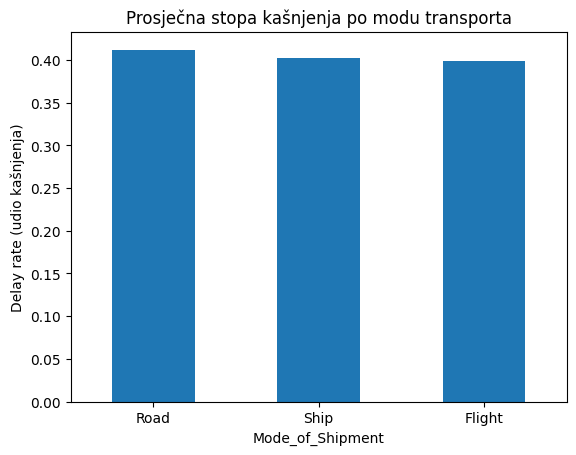

,delay_flag
Mode_of_Shipment,
Road,0.411932
Ship,0.402439
Flight,0.398424


In [ ]:
delay_by_mode = df.groupby("Mode_of_Shipment")["delay_flag"].mean().sort_values(ascending=False)

plt.figure()
delay_by_mode.plot(kind="bar")
plt.title("Prosječna stopa kašnjenja po modu transporta")
plt.ylabel("Delay rate (udio kašnjenja)")
plt.xlabel("Mode_of_Shipment")
plt.xticks(rotation=0)
plt.show()

delay_by_mode

## 5.2 Stopa kašnjenja po skladištu

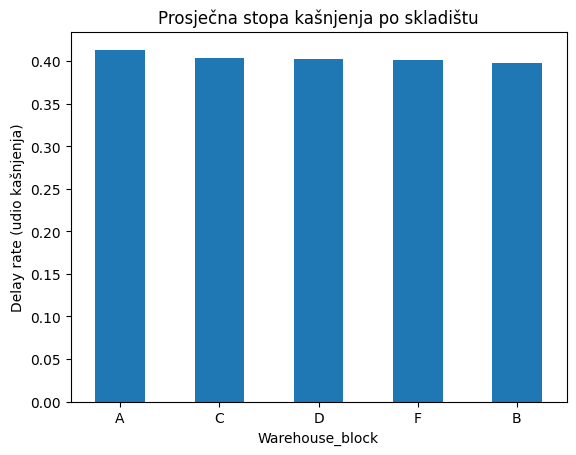

,delay_flag
Warehouse_block,
A,0.413530
C,0.403164
D,0.402399
F,0.401528
B,0.397709


In [ ]:
delay_by_wh = df.groupby("Warehouse_block")["delay_flag"].mean().sort_values(ascending=False)

plt.figure()
delay_by_wh.plot(kind="bar")
plt.title("Prosječna stopa kašnjenja po skladištu")
plt.ylabel("Delay rate (udio kašnjenja)")
plt.xlabel("Warehouse_block")
plt.xticks(rotation=0)
plt.show()

delay_by_wh

U datasetu nema vremenskih varijabli (datum, mjesec, sezona) stoga sezonski trendovi nisu mogli biti analizirani

## 5.3 Numeričke varijable: osnovna statistika i korelacije

In [ ]:
num_cols_tmp = X.select_dtypes(include=np.number).columns.tolist()
X[num_cols_tmp].describe()

,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729
std,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251
min,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000


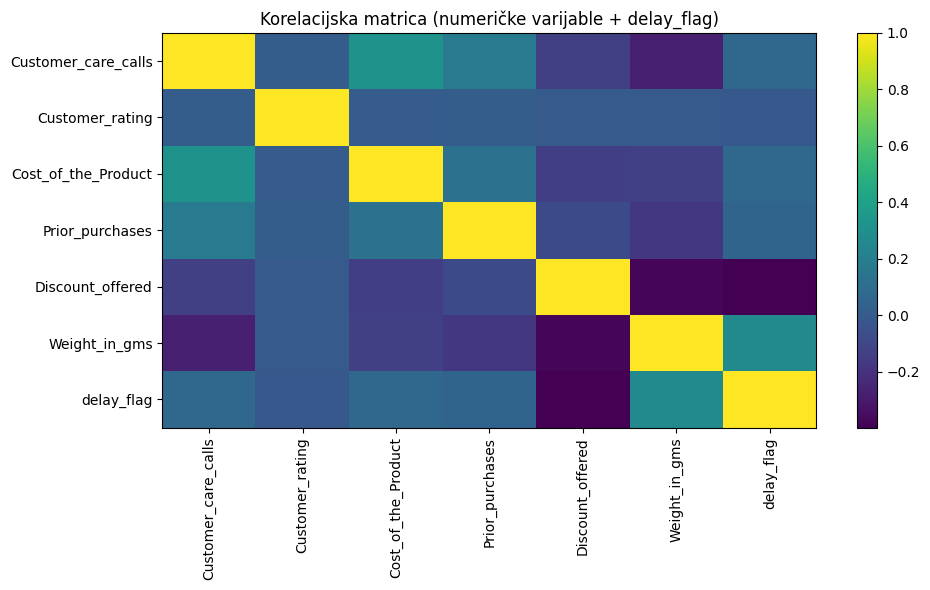

,delay_flag
delay_flag,1.000000
Weight_in_gms,0.268793
Cost_of_the_Product,0.073587
Customer_care_calls,0.067126
Prior_purchases,0.055515
Customer_rating,-0.013119
Discount_offered,-0.397108


In [ ]:
corr_df = df[num_cols_tmp + ["delay_flag"]].corr(numeric_only=True)

plt.figure(figsize=(10, 6))
plt.imshow(corr_df, aspect="auto")
plt.xticks(range(len(corr_df.columns)), corr_df.columns, rotation=90)
plt.yticks(range(len(corr_df.index)), corr_df.index)
plt.colorbar()
plt.title("Korelacijska matrica (numeričke varijable + delay_flag)")
plt.tight_layout()
plt.show()

corr_df["delay_flag"].sort_values(ascending=False)

# 6. Feature Engineering

In [ ]:
df_fe = df.copy()

# is_heavy
avg_w = df_fe["Weight_in_gms"].mean()
df_fe["is_heavy"] = (df_fe["Weight_in_gms"] > avg_w).astype(int)

# discount_category
df_fe["discount_category"] = pd.cut(
    df_fe["Discount_offered"],
    bins=[-1, 10, 30, 10_000],
    labels=["low", "medium", "high"]
)

# shipment_value = cost / weight
df_fe["shipment_value"] = (
    df_fe["Cost_of_the_Product"] / df_fe["Weight_in_gms"].replace(0, np.nan)
)
df_fe["shipment_value"] = df_fe["shipment_value"].fillna(df_fe["shipment_value"].median())

# ponovno X, y
y = df_fe["delay_flag"]
X = df_fe.drop(columns=["delay_flag", target_col])

X.head()

,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,is_heavy,discount_category,shipment_value
0,D,Flight,4,2,177,3,low,F,44,1233,0,high,0.143552
1,F,Flight,4,5,216,2,low,M,59,3088,0,high,0.069948
2,A,Flight,2,2,183,4,low,M,48,3374,0,high,0.054238
3,B,Flight,3,3,176,4,medium,M,10,1177,0,low,0.149533
4,C,Flight,2,2,184,3,medium,F,46,2484,0,high,0.074074


# 7. Preprocesiranje + Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=np.number).columns.tolist()

print("Categorical cols:", cat_cols)
print("Numeric cols:", num_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

Categorical cols: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender', 'discount_category']
Numeric cols: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms', 'is_heavy', 'shipment_value']


# 8. Modeliranje 3 modela (Logistic Regression, DecisionTree, RandomForest)

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ),
}

pipelines = {
    name: Pipeline(steps=[("prep", preprocess), ("model", model)])
    for name, model in models.items()
}

# 9. Evaluacija (Accuracy, Precision, Recall, F1, ROC-AUC) + ROC krivulje

<Figure size 640x480 with 0 Axes>

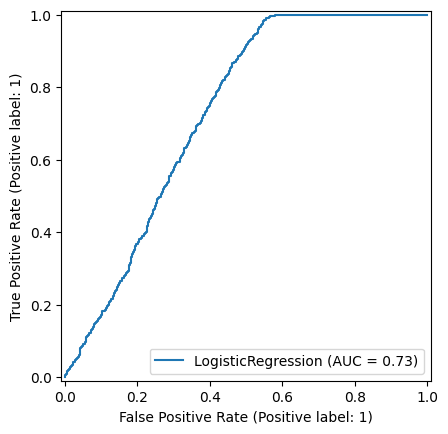

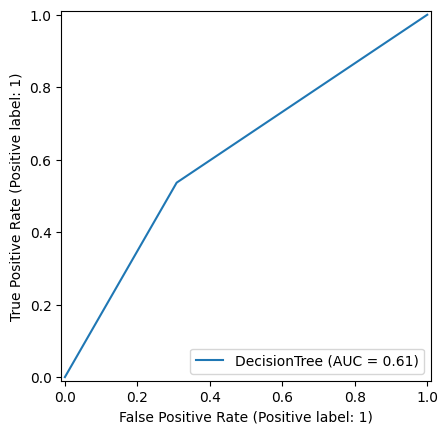

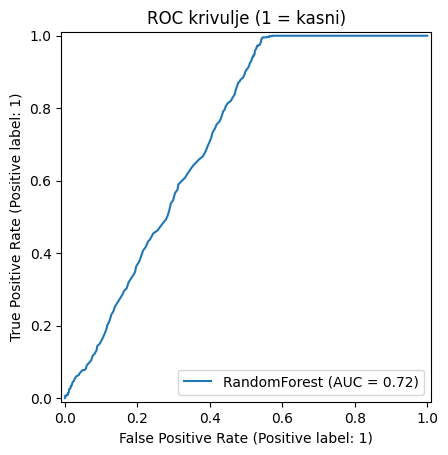

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.662727,0.557312,0.794814,0.655204,0.728475
2,RandomForest,0.638636,0.542202,0.666291,0.597876,0.722272
1,DecisionTree,0.629091,0.540295,0.536640,0.538462,0.614093


In [ ]:
def evaluate_models(pipelines, X_train, y_train, X_test, y_test):
    results = []
    plt.figure()

    for name, pipe in pipelines.items():
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        # ROC treba score/proba
        model = pipe.named_steps["model"]
        if hasattr(model, "predict_proba"):
            proba = pipe.predict_proba(X_test)[:, 1]
        else:
            proba = pipe.decision_function(X_test)

        results.append({
            "model": name,
            "accuracy": accuracy_score(y_test, preds),
            "precision": precision_score(y_test, preds),
            "recall": recall_score(y_test, preds),
            "f1": f1_score(y_test, preds),
            "roc_auc": roc_auc_score(y_test, proba),
        })

        RocCurveDisplay.from_predictions(y_test, proba, name=name)

    plt.title("ROC krivulje (1 = kasni)")
    plt.show()

    res_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)
    return res_df

results_df = evaluate_models(pipelines, X_train, y_train, X_test, y_test)
results_df


## 9.1 Vizualna usporedba ROC-AUC i F1

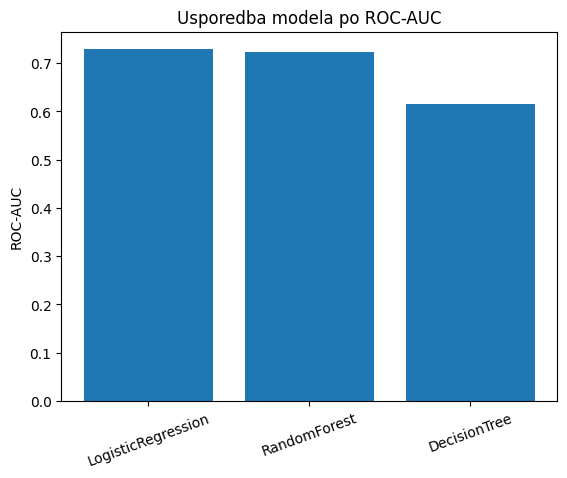

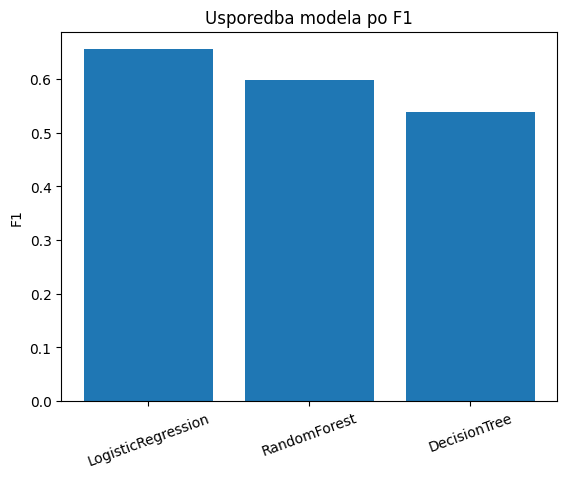

In [ ]:
plt.figure()
plt.bar(results_df["model"], results_df["roc_auc"])
plt.title("Usporedba modela po ROC-AUC")
plt.ylabel("ROC-AUC")
plt.xticks(rotation=20)
plt.show()

plt.figure()
plt.bar(results_df["model"], results_df["f1"])
plt.title("Usporedba modela po F1")
plt.ylabel("F1")
plt.xticks(rotation=20)
plt.show()


# 10. Matrica konfuzije za najbolji model

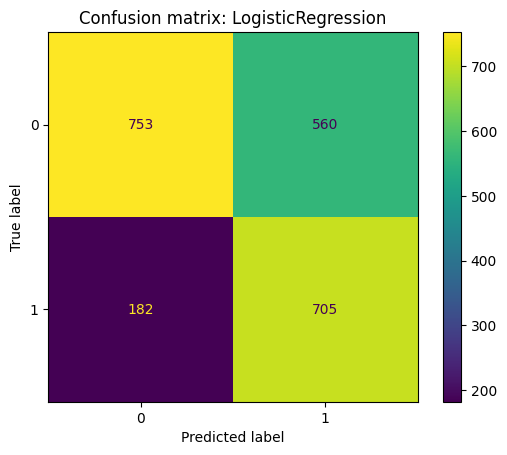

Best model: LogisticRegression


In [ ]:
best_name = results_df.iloc[0]["model"]
best_pipe = pipelines[best_name]

best_pipe.fit(X_train, y_train)
best_preds = best_pipe.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, best_preds)
plt.title(f"Confusion matrix: {best_name}")
plt.show()

print("Best model:", best_name)

# 11. Interpretacija

## 11.1 Usporedba modela

U ovom radu testirana su tri modela: logistička regresija, stablo odluke i Random Forest.
Evaluacija je provedena pomoću metrika accuracy, precision, recall, F1-score i ROC-AUC.
Rezultati pokazuju da je logistička regresija ostvarila najbolju ukupnu ravnotežu performansi, posebno prema ROC-AUC i F1-score metrikama.
To sugerira da su odnosi između značajki i kašnjenja u velikoj mjeri linearnog karaktera, te da složeniji modeli nisu donijeli značajno poboljšanje.
Zbog toga je logistička regresija odabrana kao konačni model za interpretaciju.

## 11.2. Značajne značajke (Logistic Regression)

Koeficijenti logističke regresije omogućuju izravnu interpretaciju: <br>
pozitivan koeficijent → povećava vjerojatnost kašnjenja <br>
negativan koeficijent → smanjuje vjerojatnost kašnjenja <br>
Na temelju analize koeficijenata, identificirane su sljedeće važne značajke: <br>
- Popust (Discount_offered)
Visoki iznosi popusta povezani su s većom vjerojatnošću kašnjenja.
To može ukazivati na to da su proizvodi s velikim popustom često dio promotivnih kampanja, što povećava opterećenje logističkog sustava i dovodi do kašnjenja.<br>
- Težina pošiljke (Weight_in_gms, is_heavy)
Teže pošiljke imaju povećan rizik kašnjenja, što je očekivano jer zahtijevaju:
više vremena za rukovanje,
poseban transport,
složeniju logistiku.
Dodatna binarna značajka is_heavy dodatno potvrđuje ovaj trend.<br>
- Način dostave (Mode_of_Shipment)
Određeni načini transporta (npr. cestovni ili brodski) povezani su s većim rizikom kašnjenja u odnosu na zračni prijevoz.
To ukazuje na važnost izbora transportnog moda pri planiranju isporuka osjetljivih na vrijeme.<br>
- Skladište (Warehouse_block)
Razlike između skladišta sugeriraju da operativna učinkovitost skladišta značajno utječe na pravovremenost isporuke.
Neka skladišta imaju sustavno višu stopu kašnjenja, što može ukazivati na probleme u procesima ili kapacitetima.<br>
- Vrijednost pošiljke (shipment_value)
Omjer cijene i težine proizvoda pokazao se kao relevantna značajka.
Pošiljke s nižom vrijednošću u odnosu na težinu češće kasne, što može značiti da se takve pošiljke logistički manje prioritiziraju.

## 11.3. Praktična primjena rezultata

Dobiveni model može se koristiti u stvarnom logističkom sustavu za:<br>
- ranu identifikaciju pošiljaka s visokim rizikom kašnjenja<br>
- optimizaciju izbora načina transporta
bolje upravljanje skladišnim kapacitetima<br>
- proaktivno informiranje korisnika o mogućim kašnjenjima<br>
Time se može smanjiti broj kašnjenja, poboljšati korisničko iskustvo i smanjiti operativni troškovi.

# Zaključak

U ovom projektu razmatran je problem predviđanja kašnjenja pošiljaka u kontekstu logistike i e-trgovine pomoću povijesnih operativnih podataka.
Glavni cilj bio je razviti model strojnog učenja koji može predvidjeti hoće li pošiljka biti isporučena na vrijeme ili s kašnjenjem na temelju njezinih atributa.<br>
U analizi su uspoređena tri modela: logistička regresija, stablo odluke i Random Forest.
Na temelju više evaluacijskih metrika, uključujući točnost, F1-mjeru i ROC-AUC, logistička regresija pokazala se kao model s najboljom ukupnom izvedbom te je odabrana kao konačni model.<br>
Dobiveni rezultati potvrđuju početnu hipotezu da se kašnjenja pošiljaka mogu uspješno predvidjeti korištenjem povijesnih logističkih podataka i operativnih značajki pošiljke.<br>
Analiza koeficijenata modela pokazala je da čimbenici poput visine popusta, težine pošiljke, načina transporta, skladišta te vrijednosti pošiljke imaju značajan utjecaj na vjerojatnost kašnjenja.<br>
Iz praktične perspektive, razvijeni model može poslužiti kao alat za ranu identifikaciju pošiljaka s povećanim rizikom kašnjenja, što omogućuje proaktivno upravljanje logističkim procesima.
Primjena takvog modela može doprinijeti boljem planiranju resursa, smanjenju broja kašnjenja i povećanju zadovoljstva korisnika.<br>
Unatoč dobrim rezultatima, projekt ima određena ograničenja. Dataset ne sadrži vremenske, geografske niti vanjske čimbenike poput vremenskih uvjeta ili prometnih zagušenja, koji bi mogli dodatno utjecati na isporuke.
Budući rad mogao bi uključivati proširenje skupa značajki, primjenu unakrsne validacije, optimizaciju hiperparametara te ispitivanje naprednijih modela strojnog učenja.